### ML Homework 1 | 207850074 | 211624796
importing libraries and read data file:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

data= pd.read_csv('assignment-1-data.csv')
df= pd.read_csv('assignment-1-data.csv')

# Section A | Coding

##  Decision Tree Classifier
Our implementation uses recursive splitting based on Gini index to build and train the decision tree, and supports prediction by traversing the constructed tree:

In [4]:
#Decision Tree Classifier

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split and best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    # Finds the best split for the dataset based on the Gini index.
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        min_gini = float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_gini = self.weighted_gini_index(left_y, right_y)
                    if curr_gini < min_gini:
                        best_split = {
                            "feature_index": feature_index,
                            "threshold": threshold,
                            "dataset_left": dataset_left,
                            "dataset_right": dataset_right,
                            "info_gain": min_gini - curr_gini
                        }
                        min_gini = curr_gini
        return best_split if best_split else None

    # Calculates the weighted Gini index for a split.
    def weighted_gini_index(self, left_y, right_y):
        num_left = len(left_y)
        num_right = len(right_y)
        num_total = num_left + num_right
        weight_left = num_left / num_total
        weight_right = num_right / num_total
        weighted_gini = (weight_left * self.gini_index(left_y)) + (weight_right * self.gini_index(right_y))
        return weighted_gini


    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    
    def gini_index(self, y):
        class_labels, counts = np.unique(y, return_counts=True)
        gini = 1.0 - sum((count / len(y)) ** 2 for count in counts)
        return gini
        
    def calculate_leaf_value(self, Y):
        return np.bincount(Y.astype(int)).argmax()
    
    
    def fit(self, X, Y):
        Y = Y.reshape(-1, 1)  # Reshape Y to ensure it's 2D
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


##  Random Forest Classifier

In [5]:
#Random Forest classifier
from sklearn.metrics import accuracy_score
from collections import Counter


class RandomForestClassifier():
    def __init__(self, n_estimators=30, min_samples_split=2, max_depth=2, max_features=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
    
    def fit(self, X, Y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrap sample
            X_sample, Y_sample = self.bootstrap_sample(X, Y)
            # Create a decision tree
            tree = DecisionTreeClassifier(
                min_samples_split=self.min_samples_split, 
                max_depth=self.max_depth
            )
            tree.fit(X_sample, Y_sample)
            self.trees.append(tree)
    
    def bootstrap_sample(self, X, Y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], Y[indices]
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return y_pred

## Decision Tree Regressor 

In [6]:
#DecisionTreeRegressor
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split and best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    #Finds the best split for the dataset based on the sum of squared residuals (SSR).
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        min_ssr = float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_ssr = self.weighted_ssr(left_y, right_y)
                    if curr_ssr < min_ssr:
                        best_split = {
                            "feature_index": feature_index,
                            "threshold": threshold,
                            "dataset_left": dataset_left,
                            "dataset_right": dataset_right,
                            "info_gain": self.calculate_info_gain(y, left_y, right_y, curr_ssr)
                        }
                        min_ssr = curr_ssr
        return best_split if best_split else None

    def weighted_ssr(self, left_y, right_y):
        num_left = len(left_y)
        num_right = len(right_y)
        num_total = num_left + num_right
        weight_left = num_left / num_total
        weight_right = num_right / num_total
        weighted_ssr = (weight_left * self.sum_squared_residuals(left_y)) + (weight_right * self.sum_squared_residuals(right_y))
        return weighted_ssr

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def sum_squared_residuals(self, y):
        mean = np.mean(y)
        ssr = np.sum((y - mean) ** 2)
        return ssr
    
    def calculate_leaf_value(self, Y):
        return np.mean(Y)
    
    def calculate_info_gain(self, parent, left, right, weighted_ssr):
        return np.sum((parent - np.mean(parent)) ** 2) - weighted_ssr
    
    
    def fit(self, X, Y):
        Y = Y.reshape(-1, 1)  # Reshape Y to ensure it's 2D
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):      
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

## Random Forest Regressor

In [7]:
#RandomForestRegressor
class RandomForestRegressor():
    def __init__(self, n_estimators=30, min_samples_split=2, max_depth=2):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, Y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, Y_sample = self.bootstrap_sample(X, Y)
            tree = DecisionTreeRegressor(
                min_samples_split=self.min_samples_split, 
                max_depth=self.max_depth
            )
            tree.fit(X_sample, Y_sample)
            self.trees.append(tree)
    
    def bootstrap_sample(self, X, Y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], Y[indices]
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Average predictions for regression using mean
        y_pred = np.mean(tree_preds, axis=0)
        return y_pred

### Please note: Evaluation and hyperparameter tuning will be executed after Data Prep. in the section below 

# Section B - Data Visualization
**Note**: to discover relevant insights we will Simplify the 'Condition' to 'New' and 'Refurbished' as mentioned in the next  section

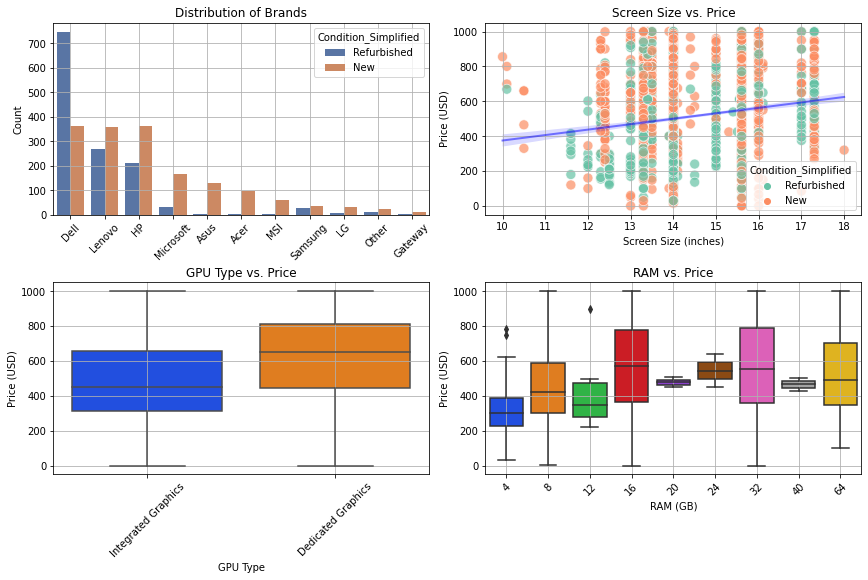

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Simplify the 'Condition' column
data['Condition_Simplified'] = data['Condition'].apply(
    lambda x: 'New' if 'New' in x or 'Open box' in x else 'Refurbished'
)

# Parameters for the grid of plots
plot_width = 12
plot_height = 8
spacing = 0.5  # Adjust as needed

# Create the subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(plot_width, plot_height))

# Plot 1: Distribution of Brands
ax = axes[0, 0]
top_brands = data['Brand'].value_counts().nlargest(10).index
temp_series = pd.Series(np.where(data['Brand'].isin(top_brands), data['Brand'], 'Other'))
sns.countplot(x=temp_series, hue=data['Condition_Simplified'], order=temp_series.value_counts().index, palette='deep', ax=ax)
ax.set_title('Distribution of Brands')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)

# Plot 2: Screen Size vs. Price (Scatter Plot)
ax = axes[0, 1]
sns.scatterplot(x='Screen_Size', y='Price', hue='Condition_Simplified', data=data, palette='Set2', s=100, edgecolor='w', alpha=0.7, ax=ax)
sns.regplot(x='Screen_Size', y='Price', data=data, scatter=False, color='blue', line_kws={'linewidth':2, 'alpha':0.5}, ax=ax)
ax.set_title('Screen Size vs. Price')
ax.set_xlabel('Screen Size (inches)')
ax.set_ylabel('Price (USD)')
ax.grid(True)

# Plot 3: GPU_Type vs. Price
ax = axes[1, 0]
sns.boxplot(x='GPU_Type', y='Price', data=data, palette='bright', ax=ax)
ax.set_title('GPU Type vs. Price')
ax.set_xlabel('GPU Type')
ax.set_ylabel('Price (USD)')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)

# Plot 4: RAM vs. Price
ax = axes[1, 1]
sns.boxplot(x='RAM', y='Price', data=data, palette='bright', ax=ax)
ax.set_title('RAM vs. Price')
ax.set_xlabel('RAM (GB)')
ax.set_ylabel('Price (USD)')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)



# Adjust layout and spacing
plt.tight_layout(pad=spacing)
plt.show()

# Data Analysis and Observations

## Plot 1: Distribution of Brands

**Description:**  
This plot shows the distribution of the top 10 brands in the dataset, categorized by their simplified condition (New or Refurbished).

**Key Observations:**
- The distribution of brands is quite varied, with some brands having a higher representation in the dataset.
- There is a noticeable difference in the number of new vs. refurbished items for certain brands.

**Insights for Condition Prediction:**
- Brands could be a significant factor in predicting the condition of a product. Certain brands might have a higher likelihood of being in a new or refurbished state.

## Plot 2: Screen Size vs. Price (With Condition)

**Description:**  
This scatter plot illustrates the relationship between screen size and price, with a regression line indicating the trend. The points are colored based on the simplified condition of the product.

**Key Observations:**
- There is a positive correlation between screen size and price, meaning larger screen sizes tend to have higher prices.
- The condition of the product does not seem to have a strong impact on the relationship between screen size and price.

**Insights for Price Prediction:**
- Screen size is an important predictor for price, as larger screens generally command higher prices.
- The simplified condition might have a minor impact on price but is not as strong a predictor as screen size.

## Plot 3: GPU Type vs. Price

**Description:**  
This box plot compares the price distribution across different GPU types.

**Key Observations:**
- Items with dedicated graphics generally have a higher price range compared to those with integrated graphics.
- There is a considerable variation in prices within each GPU type category.

**Insights for Price Prediction:**
- GPU type is a significant predictor for price, with dedicated graphics usually associated with higher prices.
- The variation within each GPU type suggests that other factors also play a role in determining the price, but GPU type remains a key factor.

## Plot 4: RAM vs. Price

**Description:**  
This box plot compares the price distribution across different RAM sizes.

**Key Observations:**
- There is a certain trend showing that higher RAM sizes tend to be associated with higher prices.
- The median price increases as the RAM size increases, with 32GB RAM configurations generally having the highest prices.
- There is a significant variation in prices within each RAM category, indicating that **other factors** besides RAM also influence the price.

**Insights for Price Prediction:**
-
- The variability within each RAM category suggests that while RAM is an important factor, other features such as brand, processor, and GPU type also play significant roles in determining the price.
- Incorporating RAM size into a price prediction model will likely improve its accuracy, as it provides a clear indication of the product's performance capabilities, which are reflected in its price.  (higher RAM configurations are generally more expensive).
  **Therefore, we tried to visualise this correlation**

# Section B -  Data Prep
## Creating Data for Classifier

In [9]:
#data for classifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
data['Condition'] = data['Condition'].replace({
    'New': 1, 'Open box': 1,
    'Excellent - Refurbished': 0,
    'Very Good - Refurbished': 0,
    'Good - Refurbished': 0
})

data['Resolution'] = data['Resolution'].fillna('0 x 0')
# Convert Resolution to Total_Pixels instead of making it categorical
def calculate_pixels(resolution):
    try:
        width, height = map(int, resolution.split(' x '))
        return width * height * 0.00001
    except ValueError:
        return 0 

data['Total_Pixels'] = data['Resolution'].apply(calculate_pixels)
mean_total_pixels = data['Total_Pixels'].mean()
data['Total_Pixels'] = data['Total_Pixels'].replace(0, mean_total_pixels)

#Encode categorical features
label_encoders = {}
for column in ['Brand', 'Processor', 'GPU', 'GPU_Type']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

imputer = SimpleImputer(strategy='mean')
data['Screen_Size'] = imputer.fit_transform(data[['Screen_Size']])

imputer = SimpleImputer(strategy='most_frequent')
for column in ['Brand', 'Processor', 'GPU', 'GPU_Type']:
    data[column] = imputer.fit_transform(data[[column]])

#Apply KNN imputation
data['Price'] = data['Price'].apply(lambda x: np.nan if x < 1 else x)
knn_imputer = KNNImputer(n_neighbors=5)
features = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Total_Pixels', 'Price']
data[features] = knn_imputer.fit_transform(data[features])

X = data[features].values
y = data['Condition'].values

#Split the data
X_train = X[:2058]
y_train = y[:2058]
X_val = X[2058:2499]
y_val = y[2058:2499]
X_test = X[2499:]
y_test = y[2499:]

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

data['Price_Category'] = pd.qcut(data['Price'], q=4, labels=False)
inputs_imputed = pd.DataFrame(X, columns=features)
inputs_imputed['Condition'] = y

please note we Converted Resolution to Total_Pixels instead of making it categorical
#### Benefits of This Approach:
- **Numerical Representation:**
   Converts resolution to a numerical representation (total pixels), enabling the model to use this feature more effectively.
  
- **Handling Missing and Invalid Data:**
   Ensures the 'Total_Pixels' column does not contain gaps or invalid values, leading to a more robust model.

- **Feature Engineering:**
   Creating 'Total_Pixels' from the 'Resolution' column is a form of feature engineering that can help the model learn patterns related to screen resolution.

## Creating data for regresor

In [10]:
#data for regressor
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error

df['Resolution'] = df['Resolution'].fillna('0 x 0')
# Convert Resolution to Total_Pixels instead of making it categorical
def calculate_pixels(resolution):
    try:
        width, height = map(int, resolution.split(' x '))
        return width * height * 0.00001
    except ValueError:
        return 0  
df['Total_Pixels'] = df['Resolution'].apply(calculate_pixels)
mean_total_pixels = df['Total_Pixels'].mean()
df['Total_Pixels'] = df['Total_Pixels'].replace(0, mean_total_pixels)

#Encode categorical features
label_encoders = {}
for column in ['Brand', 'Processor', 'GPU', 'GPU_Type', 'Condition']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

#Apply KNN imputation
df['Price'] = df['Price'].apply(lambda x: np.nan if x < 1 else x)
knn_imputer = KNNImputer(n_neighbors=5)
features_reg = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Total_Pixels', 'Condition', 'Price']
df[features_reg] = knn_imputer.fit_transform(df[features_reg])

df.dropna(inplace=True)

#Define features and target
X_reg = df[['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Total_Pixels', 'Condition']].values
y_reg = df['Price'].values  # Use 'Price' as the target variable

#Split the data
X_train_reg = X_reg[:2058]
y_train_reg = y_reg[:2058]
X_val_reg = X_reg[2058:2499]
y_val_reg = y_reg[2058:2499]
X_test_reg = X_reg[2499:]
y_test_reg = y_reg[2499:]

# EVALUATIONS AND HYPERPARAMETER TUNINGS FUNCTIONS 
#### (Continues Coding Section )
results will appear at section C - implementation

# Decision Tree Classifier evaluation and tuning

In [11]:
#function for DecisionTreeClassifier and hyperparameters
from sklearn.metrics import accuracy_score
import time

def train_evaluate_and_tune_decision_tree(X_train, y_train, X_val, y_val, X_test, y_test):
    start_time = time.time()
    
    def train_and_evaluate_dt(min_samples_split, max_depth):
        model = DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        return accuracy, model

    # Initial training and validation
    initial_model = DecisionTreeClassifier(min_samples_split=10, max_depth=15)
    initial_model.fit(X_train, y_train)
    y_val_pred_initial = initial_model.predict(X_val)
    initial_accuracy = accuracy_score(y_val, y_val_pred_initial)
    print(f"Initial Validation Accuracy: {initial_accuracy * 100:.2f}%")

    # Hyperparameter tuning using a manual grid search
    param_grid = {
        'min_samples_split': [2, 5, 10],
        'max_depth': [10, 15, 20]
    }
    
    best_accuracy = 0
    best_params = None
    best_model = None

    for min_samples_split in param_grid['min_samples_split']:
        for max_depth in param_grid['max_depth']:
            accuracy, model = train_and_evaluate_dt(min_samples_split, max_depth)
            print(f"Accuracy: {accuracy * 100:.2f}%, Params: min_samples_split={min_samples_split}, max_depth={max_depth}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = (min_samples_split, max_depth)
                best_model = model

    print(f"Best parameters: min_samples_split={best_params[0]}, max_depth={best_params[1]}")
    print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")

    # Test the best model on the test set
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    end_time = time.time()
    total_elapsed_time = end_time - start_time
    print(f"Total runtime: {total_elapsed_time:.2f} seconds")
    
    return best_model, best_params, best_accuracy, test_accuracy * 100, y_test_pred


# Random Forest Classifier evaluation and tuning

In [12]:
import time
from sklearn.metrics import accuracy_score

def train_evaluate_and_tune_random_forest(X_train, y_train, X_val, y_val, X_test, y_test):
    start_time = time.time()
    
    y_train_flat = y_train.flatten()
    y_val_flat = y_val.flatten()
    y_test_flat = y_test.flatten()

    def train_and_evaluate_rf(n_estimators, min_samples_split, max_depth):
        model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, max_depth=max_depth)
        model.fit(X_train, y_train_flat)
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val_flat, y_val_pred)
        return accuracy, model

    initial_rf_model = RandomForestClassifier(n_estimators=30, min_samples_split=10, max_depth=15)
    initial_rf_model.fit(X_train, y_train_flat)
    y_val_pred_initial_rf = initial_rf_model.predict(X_val)
    initial_accuracy_rf = accuracy_score(y_val_flat, y_val_pred_initial_rf)
    print(f"Initial Validation Accuracy: {initial_accuracy_rf * 100:.2f}%")

    # Hyperparameter tuning using a manual grid search
    param_grid_rf = {
        #we chose 30 because we faund it to be optimal in run-time + accuracy. and the added tuning for it took too long
        'n_estimators': [30],
        'min_samples_split': [2, 5, 10],
        'max_depth': [10, 15]
    }
    best_accuracy_rf = 0
    best_params_rf = None
    best_model_rf = None

    for n_estimators in param_grid_rf['n_estimators']:
        for min_samples_split in param_grid_rf['min_samples_split']:
            for max_depth in param_grid_rf['max_depth']:
                accuracy_rf, model_rf = train_and_evaluate_rf(n_estimators, min_samples_split, max_depth)
                print(f"Accuracy: {accuracy_rf * 100:.2f}%, Params: n_estimators={n_estimators}, min_samples_split={min_samples_split}, max_depth={max_depth}")
                if accuracy_rf > best_accuracy_rf:
                    best_accuracy_rf = accuracy_rf
                    best_params_rf = (n_estimators, min_samples_split, max_depth)
                    best_model_rf = model_rf

    print(f"Best parameters: n_estimators={best_params_rf[0]}, min_samples_split={best_params_rf[1]}, max_depth={best_params_rf[2]}")
    print(f"Best Validation Accuracy: {best_accuracy_rf * 100:.2f}%")

    # Test the best model on the test set
    y_test_pred_rf = best_model_rf.predict(X_test)
    test_accuracy_rf = accuracy_score(y_test_flat, y_test_pred_rf)
    acc_classification_rf = test_accuracy_rf * 100
    print(f"Test Accuracy: {test_accuracy_rf * 100:.2f}%")

    end_time = time.time()
    total_elapsed_time = end_time - start_time
    print(f"Total runtime: {total_elapsed_time:.2f} seconds")
    
    return best_model_rf, best_params_rf, best_accuracy_rf, acc_classification_rf, y_test_pred_rf


# Decision Tree Regressor evaluation and tuning

In [13]:
import time
from sklearn.metrics import mean_squared_error

def train_evaluate_and_tune_decision_tree_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, y_test_reg):
    start_time = time.time()
    
    def train_and_evaluate_dtr(min_samples_split, max_depth):
        model = DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=max_depth)
        model.fit(X_train_reg, y_train_reg)
        y_val_pred = model.predict(X_val_reg)
        mse = mean_squared_error(y_val_reg, y_val_pred)
        return mse, model

    initial_dtr_model = DecisionTreeRegressor(min_samples_split=10, max_depth=15)
    initial_dtr_model.fit(X_train_reg, y_train_reg)
    y_val_pred_initial_dtr = initial_dtr_model.predict(X_val_reg)
    initial_mse_dtr = mean_squared_error(y_val_reg, y_val_pred_initial_dtr)
    print(f"Initial Validation MSE: {initial_mse_dtr:.2f}")

    # Hyperparameter tuning using a manual grid search
    param_grid_dtr = {
        'min_samples_split': [2, 5, 10],
        'max_depth': [10, 15, 20]
    }

    best_mse_dtr = float('inf')
    best_params_dtr = None
    best_model_dtr = None

    for min_samples_split in param_grid_dtr['min_samples_split']:
        for max_depth in param_grid_dtr['max_depth']:
            mse_dtr, model_dtr = train_and_evaluate_dtr(min_samples_split, max_depth)
            print(f"MSE: {mse_dtr:.2f}, Params: min_samples_split={min_samples_split}, max_depth={max_depth}")
            if mse_dtr < best_mse_dtr:
                best_mse_dtr = mse_dtr
                best_params_dtr = (min_samples_split, max_depth)
                best_model_dtr = model_dtr

    print(f"Best parameters: min_samples_split={best_params_dtr[0]}, max_depth={best_params_dtr[1]}")
    print(f"Best Validation MSE: {best_mse_dtr:.2f}")

    # Test the best model on the test set
    y_test_pred_dtr = best_model_dtr.predict(X_test_reg)
    test_mse_dtr = mean_squared_error(y_test_reg, y_test_pred_dtr)
    print(f"Test MSE: {test_mse_dtr:.2f}")

    end_time = time.time()
    total_elapsed_time = end_time - start_time
    print(f"Total runtime: {total_elapsed_time:.2f} seconds")
    
    return best_model_dtr, best_params_dtr, best_mse_dtr, test_mse_dtr, y_test_pred_dtr

# Random Forest Regressor evaluation and tuning

In [14]:
import time
from sklearn.metrics import mean_squared_error

def train_evaluate_and_tune_random_forest_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, y_test_reg):
    start_time = time.time()
    
    def train_and_evaluate_rfr(n_estimators, min_samples_split, max_depth):
        model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, max_depth=max_depth)
        model.fit(X_train_reg, y_train_reg)
        y_val_pred = model.predict(X_val_reg)
        mse = mean_squared_error(y_val_reg, y_val_pred)
        return mse, model

    initial_rfr_model = RandomForestRegressor(n_estimators=30, min_samples_split=10, max_depth=15)
    initial_rfr_model.fit(X_train_reg, y_train_reg)
    y_val_pred_initial_rfr = initial_rfr_model.predict(X_val_reg)
    initial_mse_rfr = mean_squared_error(y_val_reg, y_val_pred_initial_rfr)
    print(f"Initial Validation MSE: {initial_mse_rfr:.2f}")

    # Hyperparameter tuning using a manual grid search
    param_grid_rfr = {
        #we chose 30 because we faund it to be optimal in run-time + mse. and the added tuning for it took too long
        'n_estimators': [30],
        'min_samples_split': [2, 5, 10],
        'max_depth': [10, 15]
    }

    best_mse_rfr = float('inf')
    best_params_rfr = None
    best_model_rfr = None

    for n_estimators in param_grid_rfr['n_estimators']:
        for min_samples_split in param_grid_rfr['min_samples_split']:
            for max_depth in param_grid_rfr['max_depth']:
                mse_rfr, model_rfr = train_and_evaluate_rfr(n_estimators, min_samples_split, max_depth)
                print(f"MSE: {mse_rfr:.2f}, Params: n_estimators={n_estimators}, min_samples_split={min_samples_split}, max_depth={max_depth}")
                if mse_rfr < best_mse_rfr:
                    best_mse_rfr = mse_rfr
                    best_params_rfr = (n_estimators, min_samples_split, max_depth)
                    best_model_rfr = model_rfr

    print(f"Best parameters: n_estimators={best_params_rfr[0]}, min_samples_split={best_params_rfr[1]}, max_depth={best_params_rfr[2]}")
    print(f"Best Validation MSE: {best_mse_rfr:.2f}")

    # Test the best model on the test set
    y_test_pred_rfr = best_model_rfr.predict(X_test_reg)
    test_mse_rfr = mean_squared_error(y_test_reg, y_test_pred_rfr)
    print(f"Test MSE: {test_mse_rfr:.2f}")

    end_time = time.time()
    total_elapsed_time = end_time - start_time
    print(f"Total runtime: {total_elapsed_time:.2f} seconds")
    
    return best_model_rfr, best_params_rfr, best_mse_rfr, test_mse_rfr, y_test_pred_rfr

 # Section C - Implementation
 # Classification - Decision Tree
 RESULTS:

 

In [32]:

# Train and evaluate models for decision tree
best_model_dt, best_params_dt, best_accuracy_dt, test_accuracy_dt, y_test_pred_dt = train_evaluate_and_tune_decision_tree(X_train, y_train, X_val, y_val, X_test, y_test)

Initial Validation Accuracy: 81.41%
Accuracy: 81.18%, Params: min_samples_split=2, max_depth=10
Accuracy: 79.82%, Params: min_samples_split=2, max_depth=15
Accuracy: 80.95%, Params: min_samples_split=2, max_depth=20
Accuracy: 80.95%, Params: min_samples_split=5, max_depth=10
Accuracy: 80.05%, Params: min_samples_split=5, max_depth=15
Accuracy: 80.95%, Params: min_samples_split=5, max_depth=20
Accuracy: 82.31%, Params: min_samples_split=10, max_depth=10
Accuracy: 81.41%, Params: min_samples_split=10, max_depth=15
Accuracy: 82.31%, Params: min_samples_split=10, max_depth=20
Best parameters: min_samples_split=10, max_depth=10
Best Validation Accuracy: 82.31%
Test Accuracy: 78.86%
Total runtime: 113.96 seconds


 # Classification - Random Forest
 RESULTS:

In [15]:

# Train and evaluate models for random forest
best_model_rf, best_params_rf, best_accuracy_rf, test_accuracy_rf, y_test_pred_rf = train_evaluate_and_tune_random_forest(X_train, y_train, X_val, y_val, X_test, y_test)

Initial Validation Accuracy: 83.90%
Accuracy: 84.81%, Params: n_estimators=30, min_samples_split=2, max_depth=10
Accuracy: 86.17%, Params: n_estimators=30, min_samples_split=2, max_depth=15
Accuracy: 83.90%, Params: n_estimators=30, min_samples_split=5, max_depth=10
Accuracy: 83.22%, Params: n_estimators=30, min_samples_split=5, max_depth=15
Accuracy: 86.17%, Params: n_estimators=30, min_samples_split=10, max_depth=10
Accuracy: 84.58%, Params: n_estimators=30, min_samples_split=10, max_depth=15
Best parameters: n_estimators=30, min_samples_split=2, max_depth=15
Best Validation Accuracy: 86.17%
Test Accuracy: 84.09%
Total runtime: 2489.06 seconds


 # Regressor - Decision Tree 
 RESULTS:

In [33]:
# Train and evaluate models for Decision Tree Regressor
best_model_dtr, best_params_dtr, best_mse_dtr, test_mse_dtr, y_test_pred_dtr = train_evaluate_and_tune_decision_tree_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, y_test_reg)

Initial Validation MSE: 37623.63
MSE: 48272.86, Params: min_samples_split=2, max_depth=10
MSE: 48682.71, Params: min_samples_split=2, max_depth=15
MSE: 48682.71, Params: min_samples_split=2, max_depth=20
MSE: 43830.18, Params: min_samples_split=5, max_depth=10
MSE: 43799.17, Params: min_samples_split=5, max_depth=15
MSE: 43799.17, Params: min_samples_split=5, max_depth=20
MSE: 37619.28, Params: min_samples_split=10, max_depth=10
MSE: 37623.63, Params: min_samples_split=10, max_depth=15
MSE: 37623.63, Params: min_samples_split=10, max_depth=20
Best parameters: min_samples_split=10, max_depth=10
Best Validation MSE: 37619.28
Test MSE: 34008.45
Total runtime: 29.24 seconds


# Regressor - Random Forest
RESULTS:

In [34]:

# Train and evaluate models for Random Forest Regressor
best_model_rfr, best_params_rfr, best_mse_rfr, test_mse_rfr, y_test_pred_rfr = train_evaluate_and_tune_random_forest_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, y_test_reg)

Initial Validation MSE: 30429.52
MSE: 31277.41, Params: n_estimators=30, min_samples_split=2, max_depth=10
MSE: 31834.90, Params: n_estimators=30, min_samples_split=2, max_depth=15
MSE: 30895.56, Params: n_estimators=30, min_samples_split=5, max_depth=10
MSE: 31696.10, Params: n_estimators=30, min_samples_split=5, max_depth=15
MSE: 30728.22, Params: n_estimators=30, min_samples_split=10, max_depth=10
MSE: 29557.25, Params: n_estimators=30, min_samples_split=10, max_depth=15
Best parameters: n_estimators=30, min_samples_split=10, max_depth=15
Best Validation MSE: 29557.25
Test MSE: 27711.79
Total runtime: 516.69 seconds


# Section D | Comparison | Using Sklearn
## Sklearn Classifiers:

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
import time


y_train_flat = y_train.ravel()
y_val_flat = y_val.ravel()
y_test_flat = y_test.ravel()

# Decision Tree Classifier with GridSearchCV
dt_param_grid = {
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 15, 20]
}

print_separator()
print("Sklearn Decision Tree Classifier")
print_separator()

start_time = time.time()
dt_grid_search = GridSearchCV(SklearnDecisionTreeClassifier(), dt_param_grid, cv=3, scoring='accuracy')
dt_grid_search.fit(X_train, y_train_flat)
best_dt_model = dt_grid_search.best_estimator_
y_val_pred = best_dt_model.predict(X_val)
dt_accuracy = accuracy_score(y_val_flat, y_val_pred)
end_time = time.time()

print(f"Best Params: {dt_grid_search.best_params_}")
print(f"Validation Accuracy: {dt_accuracy * 100:.2f}%")
print(f"Runtime: {end_time - start_time:.4f} seconds")

# Test the best Decision Tree model on the test set
y_test_pred_dt = best_dt_model.predict(X_test)
test_accuracy_dt = accuracy_score(y_test_flat, y_test_pred_dt)
acc_classification_tree = test_accuracy_dt * 100
print(f"Test Accuracy:  {test_accuracy_dt * 100:.2f}%")

print_separator()


# Random Forest Classifier with GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 15, 20]
}

print("Sklearn Random Forest Classifier")
print_separator()

start_time = time.time()
rf_grid_search = GridSearchCV(SklearnRandomForestClassifier(), rf_param_grid, cv=3, scoring='accuracy')
rf_grid_search.fit(X_train, y_train_flat)
best_rf_model = rf_grid_search.best_estimator_
y_val_pred_rf = best_rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val_flat, y_val_pred_rf)
end_time = time.time()

print(f"Best Params: {rf_grid_search.best_params_}")
print(f"Validation Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Runtime: {end_time - start_time:.4f} seconds")

# Test the best Random Forest model on the test set
y_test_pred_rf = best_rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test_flat, y_test_pred_rf)
acc_classification_rf = test_accuracy_rf * 100
print(f"Test Accuracy: {test_accuracy_rf * 100:.2f}%")





Sklearn Decision Tree Classifier


Best Params: {'max_depth': 15, 'min_samples_split': 5}
Validation Accuracy: 80.50%
Runtime: 0.1532 seconds
Test Accuracy:  78.41%


Sklearn Random Forest Classifier


Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Validation Accuracy: 84.35%
Runtime: 21.6819 seconds
Test Accuracy: 84.77%


# Classifiers Comparison of Custom Implementation vs Sklearn Models

## Decision Tree Classifier

| Metric                | Sklearn Decision Tree     | Custom Decision Tree      |
|-----------------------|---------------------------|---------------------------|
| Best Params           | min_samples_split: 5, max_depth: 15 | min_samples_split=10, max_depth=10 |
| Validation Accuracy   | 80.50%                    | 82.31%                    |
| Test Accuracy         | 78.41%                    | 78.86%                    |
| Runtime (seconds)     | 0.1532                    | 113.96                    |

## Random Forest Classifier

| Metric                | Sklearn Random Forest     | Custom Random Forest      |
|-----------------------|---------------------------|---------------------------|
| Best Params           |n_estimators: 100, min_samples_split: 2, max_depth:20| n_estimators=30, min_samples_split=2, max_depth=15 |
| Validation Accuracy   | 84.35%                    | 86.17%                    |
| Test Accuracy         | 84.77%                    | 84.09%                    |
| Runtime (seconds)     | 21.6819                   | 2489.06                   |

## Comparison and Analysis

### Decision Tree Classifier

- **Validation Accuracy:**
 Both the custom and sklearn implementations show similar validation accuracies, with the custom implementation slightly higher.
- **Test Accuracy:**
 Test accuracies are also very close, with the custom implementation being marginally better.
- **Runtime:**
The custom implementation's runtime is significantly longer than the sklearn implementation. This could be due to optimizations in the sklearn library that make their implementation more efficient.

### Random Forest Classifier

- **Validation Accuracy:**
 The custom implementation has a slightly higher validation accuracy than the sklearn implementation.
- **Test Accuracy:**
  The test accuracies are very close, with the sklearn implementation being marginally better.
- **Runtime:**
  The custom implementation's runtime is significantly longer.

### Explanation for Differences

- **Optimizations in Sklearn:**
  The sklearn library is highly optimized for performance. It uses compiled C/C++ code and efficient algorithms for training models, which can significantly reduce runtime.
- **Parallel Processing:**
   Sklearn's RandomForest implementation uses parallel processing effectively, which can speed up the training process compared to a custom implementation that might not leverage parallelism as efficiently.
- **Algorithm Efficiency:**
   The internal algorithms used by sklearn are fine-tuned for performance, which might not be the case for a custom implementation.
- **Memory Management:**
   Sklearn handles memory management efficiently, reducing the overhead during model training.

### Conclusion for Classifiers

- **Custom Implementation:**
  - Offers competitive accuracy but at the cost of significantly increased runtime.
  - **NOTE**: We will discuss about our accuracy later on at final Conclusions
 
- **Sklearn Implementation:**
  - Provides optimized and efficient models with faster runtimes.



## Sklearn Regressors:

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor as SklearnDecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor
import time

y_train_reg_flat = y_train_reg.ravel()
y_val_reg_flat = y_val_reg.ravel()
y_test_reg_flat = y_test_reg.ravel()

def print_separator():
    print("\n" + "="*50 + "\n")

# Decision Tree Regressor with GridSearchCV
dtr_param_grid = {
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 15, 20]
}

print("SkLearn Decision Tree Regressor")
print_separator()

start_time_gs_dtr = time.time()
dtr_grid_search = GridSearchCV(SklearnDecisionTreeRegressor(), dtr_param_grid, cv=3, scoring='neg_mean_squared_error')
dtr_grid_search.fit(X_train_reg, y_train_reg_flat)
end_time_gs_dtr = time.time()

best_dtr_model = dtr_grid_search.best_estimator_
start_time_fit_dtr = time.time()
y_val_pred_dtr = best_dtr_model.predict(X_val_reg)
end_time_fit_dtr = time.time()

dtr_mse = mean_squared_error(y_val_reg_flat, y_val_pred_dtr)

print(f"Best Params: {dtr_grid_search.best_params_}")
print(f"Validation MSE: {dtr_mse:.2f}")
print(f"GridSearch Runtime: {end_time_gs_dtr - start_time_gs_dtr:.4f} seconds")
print(f"Prediction Runtime: {end_time_fit_dtr - start_time_fit_dtr:.4f} seconds")

# Test the best Decision Tree model on the test set
start_time_test_dtr = time.time()
y_test_pred_dtr = best_dtr_model.predict(X_test_reg)
end_time_test_dtr = time.time()

test_mse_dtr = mean_squared_error(y_test_reg_flat, y_test_pred_dtr)
print(f"Test MSE: {test_mse_dtr:.2f}")
print(f"Test Prediction Runtime: {end_time_test_dtr - start_time_test_dtr:.4f} seconds")

print_separator()

# Random Forest Regressor with GridSearchCV
rfr_param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 15, 20]
}

print("SkLearn Random Forest Regressor")
print_separator()

start_time_gs_rfr = time.time()
rfr_grid_search = GridSearchCV(SklearnRandomForestRegressor(), rfr_param_grid, cv=3, scoring='neg_mean_squared_error')
rfr_grid_search.fit(X_train_reg, y_train_reg_flat)
end_time_gs_rfr = time.time()

best_rfr_model = rfr_grid_search.best_estimator_
start_time_fit_rfr = time.time()
y_val_pred_rfr = best_rfr_model.predict(X_val_reg)
end_time_fit_rfr = time.time()

rfr_mse = mean_squared_error(y_val_reg_flat, y_val_pred_rfr)

print(f"Best Params: {rfr_grid_search.best_params_}")
print(f"Validation MSE: {rfr_mse:.2f}")
print(f"GridSearch Runtime: {end_time_gs_rfr - start_time_gs_rfr:.4f} seconds")
print(f"Prediction Runtime: {end_time_fit_rfr - start_time_fit_rfr:.4f} seconds")

# Test the best Random Forest model on the test set
start_time_test_rfr = time.time()
y_test_pred_rfr = best_rfr_model.predict(X_test_reg)
end_time_test_rfr = time.time()

test_mse_rfr = mean_squared_error(y_test_reg_flat, y_test_pred_rfr)
print(f"Test MSE: {test_mse_rfr:.2f}")
print(f"Test Prediction Runtime: {end_time_test_rfr - start_time_test_rfr:.4f} seconds")

print_separator()

SkLearn Decision Tree Regressor


Best Params: {'max_depth': 10, 'min_samples_split': 10}
Validation MSE: 39725.41
GridSearch Runtime: 0.1219 seconds
Prediction Runtime: 0.0003 seconds
Test MSE: 29415.01
Test Prediction Runtime: 0.0014 seconds


SkLearn Random Forest Regressor


Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Validation MSE: 30557.37
GridSearch Runtime: 28.3786 seconds
Prediction Runtime: 0.0204 seconds
Test MSE: 26354.29
Test Prediction Runtime: 0.0214 seconds




# Regressors Comparison of Custom Implementation vs Sklearn Models
## Decision Tree Regressor

| Metric                | Sklearn Decision Tree Regressor               | Custom Decision Tree Regressor       |
|-----------------------|-----------------------------------------------|--------------------------------------|
| **Best Params**       | min_samples_split: 10, max_depth: 10     | min_samples_split=10, max_depth=10   |
| **Validation MSE**    | 39,725.41                                     | 37,619.28                            |
| **Test MSE**          | 29,415.01                                     | 34,008.45                            |
| **Total Runtime (s)** | 0.1236                                        | 29.24                                |


## Random Forest Regressor

| Metric                | Sklearn Random Forest Regressor                                 | Custom Random Forest Regressor          |
|-----------------------|-----------------------------------------------------------------|-----------------------------------------|
| **Best Params**       | n_estimators: 200 , min_samples_split: 5, max_depth: 10 | n_estimators=30, min_samples_split=10, max_depth=15 |
| **Validation MSE**    | 30,557.37                                                       | 29,557.25                               |
| **Test MSE**          | 26,354.29                                                       | 27,711.79                               |
| **Total Runtime (s)** | 28.4204                                                         | 516.69                                  |

## Comparison and Analysis

### Decision Tree Regressor

- **Validation MSE:**
  The custom implementation has a slightly lower validation MSE compared to the sklearn implementation.
- **Test MSE:**
  The test MSE of the custom implementation is higher than that of the sklearn implementation.
- **Runtime:**
   The runtime for the custom implementation is significantly longer than the sklearn implementation, which could be due to optimizations in the sklearn library.

### Random Forest Regressor

- **Validation MSE:**
   The custom implementation has a lower validation MSE compared to the sklearn implementation.
- **Test MSE:**
   The test MSE of the custom implementation is slightly higher than that of the sklearn implementation.
- **Runtime:**
   The runtime for the custom implementation is significantly longer than the sklearn implementation, which could be due to 

## Differences at runtime and conclusion
 **same as classification explanation above** (about scklearn algorithm, efficiency and memory managment)






# Final Comparisons Conclusion
Our implementations of the Decision Tree and Random Forest Classifiers and Regressors exhibit competitive performance compared to the sklearn implementations, with slightly better validation metrics in some cases.
**However, this might be influenced by several factors:**

### Overfitting
- The custom implementations may overfit the training data, leading to better performance on the validation set but not necessarily generalizing well to the test set.
- Overfitting can occur when the models capture noise and fluctuations in the training data, which do not represent the underlying data distribution.

### Data Splitting Strategy
- The data was divided into training, validation, and test sets in advance, rather than using cross-validation.

### Information Gain and Splitting Criteria
- Our Decision Tree implementations use the Gini index for splitting, which might result in different splits compared to sklearn’s implementation.
- Small differences in splitting criteria can lead to variations in tree structure and performance.

### Model Complexity
- The parameters for `min_samples_split` and `max_depth` control the complexity of the Decision Tree. Our chosen parameters may lead to a model that fits the training data well but could potentially overfit without proper cross-validation.
- For Random Forest, the number of trees (`n_estimators`) and the parameters for each tree can impact the model’s ability to generalize.

### Randomness in Data Splitting
- The initial random split of data into training, validation, and test sets can influence the performance metrics.
- The specific characteristics of the split data can make the models appear more or less effective.

### Summary

Our custom implementations of the Decision Tree and Random Forest Classifiers and Regressors show promising results but need further validation through cross-validation to ensure they generalize well to new data. By addressing potential overfitting and refining the models through regularization and better validation techniques, we can improve their robustness and reliability.

# Section E - Bonus
# Pt.1 - Screen Resolution
 **Data Prep** - Splitting the Resolution column into Height and Width:

In [17]:
#data for section e
# Split the Resolution column into Height and Width
def split_resolution(resolution):
    try:
        width, height = map(int, resolution.split(' x '))
        return width, height
    except ValueError:
        return 0, 0  # Handle any unexpected values

data[['Width', 'Height']] = data['Resolution'].apply(lambda x: pd.Series(split_resolution(x)))
data[['Width', 'Height']] = data[['Width', 'Height']].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputer only on the 'Width' and 'Height' columns
data[['Width', 'Height']] = imputer.fit_transform(data[['Width', 'Height']])


features_e_class = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type','Width', 'Height', 'Price']
X_e = data[features_e_class].values
y_e = data['Condition'].values

X_train_e = X_e[:2058]
y_train_e = y_e[:2058]
X_val_e = X_e[2058:2499]
y_val_e = y_e[2058:2499]
X_test_e = X_e[2499:]
y_test_e = y_e[2499:]

y_train_e = y_train_e.reshape(-1, 1)
y_val_e = y_val_e.reshape(-1, 1)
y_test_e = y_test_e.reshape(-1, 1)



#data for the regresor
df[['Width', 'Height']] = df['Resolution'].apply(lambda x: pd.Series(split_resolution(x)))
df[['Width', 'Height']] = df[['Width', 'Height']].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputer only on the 'Width' and 'Height' columns
df[['Width', 'Height']] = imputer.fit_transform(df[['Width', 'Height']])
features_e_reg = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Width', 'Height', 'Condition', 'Price']
df[features_e_reg] = knn_imputer.fit_transform(df[features_e_reg])


X_reg_e = df[['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type',  'Width', 'Height', 'Condition']].values
y_reg_e = df['Price'].values 

X_train_reg_e = X_reg_e[:2058]
y_train_reg_e = y_reg_e[:2058]
X_val_reg_e = X_reg_e[2058:2499]
y_val_reg_e = y_reg_e[2058:2499]
X_test_reg_e = X_reg_e[2499:]
y_test_reg_e = y_reg_e[2499:]


## Decision Tree Classifiers and Regressors 
### implementation on new data

In [24]:
print("new data classifire tree")

temp1, temp2, temp3, temp4, temp5 = train_evaluate_and_tune_decision_tree(X_train, y_train, X_val, y_val, X_test, y_test)
print("new data regressor tree")

temp6, temp7, temp8, temp9, temp10 = train_evaluate_and_tune_decision_tree_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, y_test_reg)

new data classifire tree
Initial Validation Accuracy: 81.41%
Accuracy: 81.18%, Params: min_samples_split=2, max_depth=10
Accuracy: 79.82%, Params: min_samples_split=2, max_depth=15
Accuracy: 80.95%, Params: min_samples_split=2, max_depth=20
Accuracy: 80.95%, Params: min_samples_split=5, max_depth=10
Accuracy: 80.05%, Params: min_samples_split=5, max_depth=15
Accuracy: 80.95%, Params: min_samples_split=5, max_depth=20
Accuracy: 82.31%, Params: min_samples_split=10, max_depth=10
Accuracy: 81.41%, Params: min_samples_split=10, max_depth=15
Accuracy: 82.31%, Params: min_samples_split=10, max_depth=20
Best parameters: min_samples_split=10, max_depth=10
Best Validation Accuracy: 82.31%
Test Accuracy: 78.86%
Total runtime: 274.36 seconds
new data regressor tree
Initial Validation MSE: 37623.63
MSE: 48272.86, Params: min_samples_split=2, max_depth=10
MSE: 48682.71, Params: min_samples_split=2, max_depth=15
MSE: 48682.71, Params: min_samples_split=2, max_depth=20
MSE: 43830.18, Params: min_samp

## Random Forest Classifiers and Regressors 
### implementation on new data

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score

# Classifier Example
print("Classifier forest with new data")
rf_model = RandomForestClassifier(n_estimators=30, min_samples_split=2, max_depth=15)
rf_model.fit(X_train_e, y_train_e.flatten())
y_val_pred = rf_model.predict(X_test_e)
accuracy = accuracy_score(y_test_e.flatten(), y_val_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Regressor Example
print("Regressor forest with new data")
random_forest_model_e2 = RandomForestRegressor(n_estimators=30, min_samples_split=10, max_depth=15)
random_forest_model_e2.fit(X_train_reg_e, y_train_reg_e)
y_test_pred_forest = random_forest_model_e2.predict(X_test_reg_e)
mse_forest_e2 = mean_squared_error(y_test_reg_e, y_test_pred_forest)
print(f"Random Forest Regressor Test Mean Squared Error: {mse_forest_e2:.2f}")

Classifier forest with new data
Test Accuracy: 85.23%
Regressor forest with new data
Random Forest Regressor Test Mean Squared Error: 28236.17


## Results Comparison

| Model                | Metric        | New Data  | Original Data |
|----------------------|---------------|-----------|---------------|
| Tree Classifier      | Accuracy (%)  | 78.86     | 78.86         |
| Tree Regressor       | Value         | 34008.45  | 34008.45      |
| Forest Classifier    | Accuracy (%)  | 85.23     | 84.09         |
| Forest Regressor     | Value         | 28236.17  | 277141.79     |

## Overall Discussion
#### As we can see, there are no significant differences between the results:
 As we explained at SECTION B, we used resolution as "total pixels" instead of categorizing it while we prepared the data. 
 - Simply placing the data into two different features does not alter our original approach results.



# Pt.2 - Random Forest Regression Test | Using **Median**

In [107]:
class RandomForestRegressor_median():
    def __init__(self, n_estimators=100, min_samples_split=2, max_depth=2):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, Y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, Y_sample = self.bootstrap_sample(X, Y)
            tree = DecisionTreeRegressor(
                min_samples_split=self.min_samples_split, 
                max_depth=self.max_depth
            )
            tree.fit(X_sample, Y_sample)
            self.trees.append(tree)
    
    def bootstrap_sample(self, X, Y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], Y[indices]
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Compute the median of the predictions for regression
        y_pred = np.median(tree_preds, axis=0)
        return y_pred

In [70]:
#simple activation
import numpy as np
from sklearn.metrics import mean_squared_error

random_forest_model = RandomForestRegressor_median(n_estimators=30, min_samples_split=2, max_depth=5)
random_forest_model.fit(X_train_reg, y_train_reg)
y_test_pred_forest = random_forest_model.predict(X_test_reg)
mse_forest = mean_squared_error(y_test_reg, y_test_pred_forest)
print(f"Random Forest Regressor Test Mean Squared Error: {mse_forest:.2f}")

Random Forest Regressor Test Mean Squared Error: 30012.58


# Conclusion
As we can see when we are using **Mean** in the random forest we are getting
a score of **Test MSE: 27711.19**

When using the **Median** we are getting **Test MSE: 30012.58**  

Using the mean in a Random Forest Regressor typically results in better performance than using the median due to its ability to reduce variance by averaging all the predictions from the individual trees.
This averaging effect leverages the strengths of all trees, providing a more accurate and stable prediction. 

While the median offers robustness against outliers, it tends to ignore useful variations among predictions, leading to higher Mean Squared Error (MSE) as observed in our results (Mean: 27711.19 vs. Median: 30012.58).

Therefore, the mean is generally preferred for aggregating predictions in Random Forest Regressors.


 

# Pt.3 - Classification Metric
## calculating confusion matrix:
 sensitivity | specificity | Precision | F1 | Accuracy

In [26]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # Recall
    specificity = tn / (tn + fp)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return sensitivity, specificity, precision, f1, accuracy


def calculate_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

### Decision Tree Classifier

In [30]:
# Calculate metrics for Decision Tree
sensitivity_dt, specificity_dt, precision_dt, f1_dt, accuracy_dt = calculate_metrics(y_test, y_test_pred_dt)
# printing
print("\nDecision Tree Metrics:")
print("======================")
print(f"Sensitivity (Recall): {sensitivity_dt:.2f}")
print(f"Specificity         : {specificity_dt:.2f}")
print(f"Precision           : {precision_dt:.2f}")
print(f"F1 Score            : {f1_dt:.2f}")
print(f"Accuracy            : {accuracy_dt:.2f}")


Decision Tree Metrics:
Sensitivity (Recall): 0.82
Specificity         : 0.74
Precision           : 0.83
F1 Score            : 0.82
Accuracy            : 0.79


### Random Forest Classifier

In [141]:
# Calculate metrics for Random Forest
sensitivity_rf, specificity_rf, precision_rf, f1_rf, accuracy_rf = calculate_metrics(y_test, y_test_pred_rf)
#  printing
print("\nRandom Forest Metrics:")
print("=======================")
print(f"Sensitivity (Recall): {sensitivity_rf:.2f}")
print(f"Specificity         : {specificity_rf:.2f}")
print(f"Precision           : {precision_rf:.2f}")
print(f"F1 Score            : {f1_rf:.2f}")
print(f"Accuracy            : {accuracy_rf:.2f}")


Random Forest Metrics:
Sensitivity (Recall): 0.85
Specificity         : 0.83
Precision           : 0.88
F1 Score            : 0.87
Accuracy            : 0.84


# Discussion
### Analysis of Classifier Performance

#### Metrics Comparison

| Metric               | Random Forest | Decision Tree |
|----------------------|---------------|---------------|
| Sensitivity (Recall) | 0.85          | 0.82          |
| Specificity          | 0.83          | 0.74          |
| Precision            | 0.88          | 0.83          |
| F1 Score             | 0.87          | 0.82          |
| Accuracy             | 0.84          | 0.79          |

**While the Random Forest model outperforms the Decision Tree model in all metrics, the difference is not drastic.**
#### Differences and Possible Explanations:

1. **Higher Specificity in Random Forest:**
 Random Forests are ensemble methods that aggregate the predictions of multiple decision trees. This aggregation helps reduce overfitting and provides a more generalized model. Decision Trees, being a single model, are more prone to overfitting, which can reduce their performance on unseen data, particularly affecting specificity.
Higher specificity in Random Forest means it is better at correctly identifying negative cases compared to the Decision Tree.

2. **Higher Precision in Random Forest:**
 Precision is influenced by the number of false positives. Random Forest, with its ensemble nature, tends to reduce the variance of the model, leading to fewer false positives and hence higher precision.
Higher precision indicates that when Random Forest predicts a positive case, it is more likely to be correct than the Decision Tree.

3. **Higher F1 Score in Random Forest:**
 The F1 Score is the harmonic mean of precision and recall. Given that Random Forest has higher precision and slightly higher recall, its F1 Score is also higher.
 A higher F1 Score means the Random Forest model balances precision and recall better than the Decision Tree.

4. **Higher Accuracy in Random Forest:**
The combination of higher precision, recall, and specificity leads to better overall accuracy for the Random Forest.
 Higher accuracy indicates that the Random Forest model is better at correctly classifying both positive and negative cases overall.

#### Suggested Methods to Improve Scores

1. **Hyperparameter Tuning:**
 If we had a better Machine, we could enlarge Hyperparameter and find the optimal parameters for the Decision Tree and Random Forest models.

2. **Feature Engineering:**
  Create new features or transform existing ones to provide more relevant information to the models.
  Better features can help the model learn more effectively and improve its ability to generalize.

3. **Ensemble Methods:**
 Combine the predictions of multiple models using techniques like bagging, boosting, or stacking.
   Ensemble methods can leverage the strengths of different models to improve overall performance.

4. **Regularization Techniques:**
   Implement techniques like pruning in Decision Trees or adding constraints to Random Forest models.
    Regularization helps reduce overfitting by penalizing model complexity, leading to better generalization.

5. **Cross-Validation:**
  We Could use cross-validation to evaluate the models more robustly.
   Cross-validation provides a more accurate estimate of model performance by averaging results over multiple splits, reducing the risk of overfitting to a particular train-test split.



### ***We also checked Regression Metrics for fun:***

### Decision Tree Regressor

In [153]:
# Calculate metrics for Decision Tree Regressor
mse_dtr, mae_dtr, r2_dtr = calculate_regression_metrics(y_test_reg, y_test_pred_dtr)
# printing 
print("\nDecision Tree Regressor Metrics:")
print("===============================")
print(f"MSE                : {mse_dtr:.2f}")
print(f"MAE                : {mae_dtr:.2f}")
print(f"R²                 : {r2_dtr:.2f}")


Decision Tree Regressor Metrics:
MSE                : 34816.87
MAE                : 132.45
R²                 : 0.38


### Random Forest Regressor

In [27]:
# Calculate metrics for Random Forest Regressor
mse_rfr, mae_rfr, r2_rfr = calculate_regression_metrics(y_test_reg, y_test_pred_rfr)
#  printing 
print("\nRandom Forest Regressor Metrics:")
print("===============================")
print(f"MSE                : {mse_rfr:.2f}")
print(f"MAE                : {mae_rfr:.2f}")
print(f"R²                 : {r2_rfr:.2f}")


Random Forest Regressor Metrics:
MSE                : 26354.29
MAE                : 118.24
R²                 : 0.53
